In [1]:
# 准备必要的包
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import init_utils   #第一部分，初始化
import reg_utils    #第二部分，正则化

%matplotlib inline

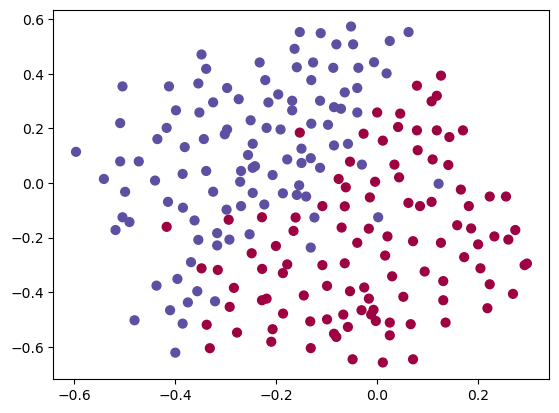

In [2]:
train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot=True)

In [3]:
def model(X,Y,learning_rate=0.3,num_iterations=30000,print_cost=True,is_plot=True,lambd=0,keep_prob=1):

    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]
    
    #初始化参数
    parameters = reg_utils.initialize_parameters(layers_dims)
    
    #开始学习
    for i in range(0,num_iterations):
        #前向传播
        ##是否随机删除节点
        if keep_prob == 1:
            ###不随机删除节点
            a3 , cache = reg_utils.forward_propagation(X,parameters)
        elif keep_prob < 1:
            ###随机删除节点
            a3 , cache = forward_propagation_with_dropout(X,parameters,keep_prob)
        else:
            print("keep_prob参数错误！程序退出。")
            exit
        
        #计算成本
        ## 是否使用二范数
        if lambd == 0:
            ###不使用L2正则化
            cost = reg_utils.compute_cost(a3,Y)
        else:
            ###使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)
        
        #反向传播
        ##可以同时使用L2正则化和随机删除节点，但是本次实验不同时使用。
        assert(lambd == 0  or keep_prob ==1)
        
        ##两个参数的使用情况
        if (lambd == 0 and keep_prob == 1):
            ### 不使用L2正则化和不使用随机删除节点
            grads = reg_utils.backward_propagation(X,Y,cache)
        elif lambd != 0:
            ### 使用L2正则化，不使用随机删除节点
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            ### 使用随机删除节点，不使用L2正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        #更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)
        
        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))
        
    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回学习后的参数
    return parameters

第0次迭代，成本值为：0.6557412523481002
第10000次迭代，成本值为：0.1632998752572419
第20000次迭代，成本值为：0.1385164242324698


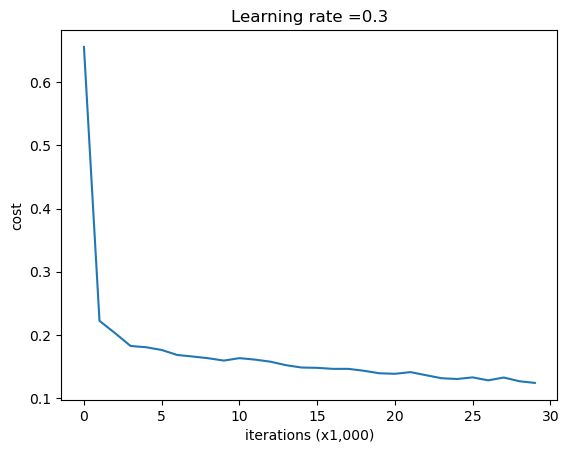

训练集:
Accuracy: 0.9478672985781991
测试集:
Accuracy: 0.915


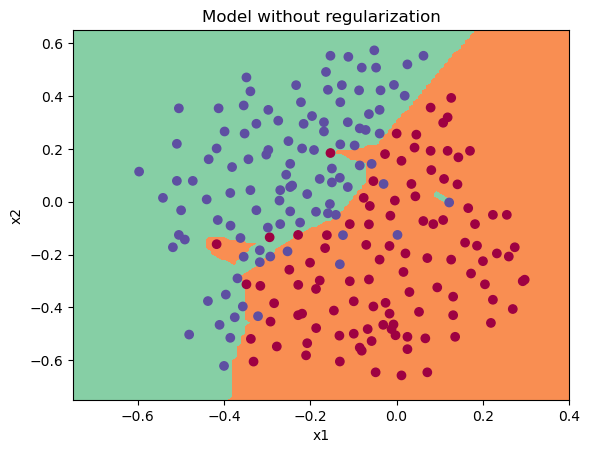

In [4]:
# 不使用正则化
parameters = model(train_X, train_Y,is_plot=True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

第0次迭代，成本值为：0.6974484493131264
第10000次迭代，成本值为：0.2684918873282238
第20000次迭代，成本值为：0.2680916337127301


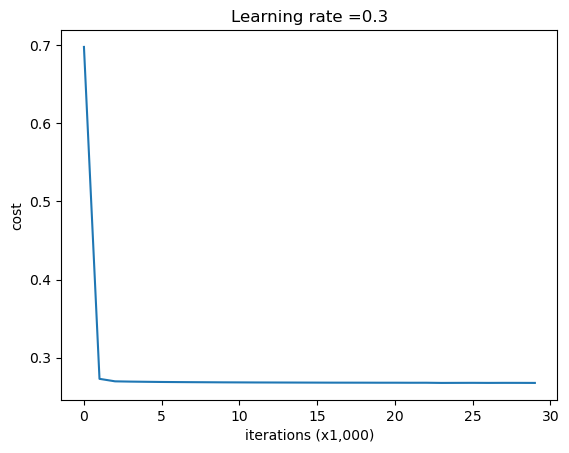

使用正则化，训练集:
Accuracy: 0.9383886255924171
使用正则化，测试集:
Accuracy: 0.93


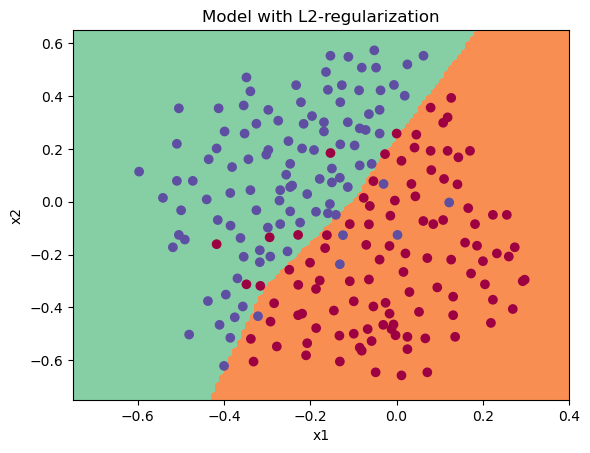

In [5]:
# 使用正则化
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = reg_utils.compute_cost(A3,Y)
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2))  + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

#当然，因为改变了成本函数，我们也必须改变向后传播的函数， 所有的梯度都必须根据这个新的成本值来计算。

def backward_propagation_with_regularization(X, Y, cache, lambd):    
    m = X.shape[1]
    
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = (1 / m) * np.dot(dZ3,A2.T) + ((lambd * W3) / m )
    db3 = (1 / m) * np.sum(dZ3,axis=1,keepdims=True)
    
    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2,A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1,X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

parameters = model(train_X, train_Y, lambd=0.7,is_plot=True)
print("使用正则化，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用正则化，测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)